# Benchmarking Retrievers

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import spacy
import time
import torch
from bs4 import BeautifulSoup
from spacy.lang.en import stop_words
from math import log2
from tqdm import tqdm
from urllib.request import urlopen

In [ ]:
!git clone https://github.com/al-the-eigenvalue/grammars

In [ ]:
def fix_random_seeds(seed):
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_random_seeds(42)

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=1.7)
plt.rcParams['font.family'] = 'Serif'

In [ ]:
filepaths_benchmark = []
filepaths_metrics = []
directory_benchmark = 'retrievers_benchmark'
directory_metrics = 'retrievers_metrics'

for filename in os.listdir(directory_benchmark):
    f_benchmark = os.path.join(directory_benchmark, filename)
    f_metrics = os.path.join(directory_metrics, filename)
    filepaths_benchmark.append(f_benchmark)
    filepaths_metrics.append(f_metrics)

filepaths_benchmark = sorted(filepaths_benchmark)
filepaths_metrics = sorted(filepaths_metrics)

In [ ]:
mapping = {
    0.0: 0,
    1.0: 1,
    2.1: 2,
    2.2: 3,
    2.3: 4,
    3.0: 5
}

mapping_binary = {
    0.0: 0,
    1.0: 0,
    2.1: 0,
    2.2: 0,
    2.3: 1,
    3.0: 1
}

for filepath in filepaths_benchmark:
    df = pd.read_csv(filepath)
    df['Relevance Score'] = df['Annotation'].map(mapping)
    df['Binary Relevance Score'] = df['Annotation'].map(mapping_binary)
    df['BM25 Rank'] = df.index + 1
    df.to_csv(filepath, index=False)

## Metric: Normalized Discounted Cumulative Gain (NDCG@K)

In [ ]:
def ndcg(relevance_scores):
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)

    dcg = 0
    idcg = 0
    ndcg = []

    for k in range(1, len(relevance_scores) + 1):
        rel_k = relevance_scores[k-1]
        ideal_rel_k = ideal_relevance_scores[k-1]
        dcg += rel_k / log2(k + 1)
        idcg += ideal_rel_k / log2(k + 1)
        ndcg.append(dcg / idcg)

    return ndcg

## The Only Language-Agnostic Ranker (aka Baseline): BM25

In [ ]:
for i, f_benchmark in enumerate(filepaths_benchmark):
    df_benchmark = pd.read_csv(f_benchmark)
    df_metrics = pd.read_csv(filepaths_metrics[i])
    df_metrics['BM25 Paragraphs'] = df_benchmark['Paragraph']
    df_metrics['BM25 Relevance Score'] = df_benchmark['Relevance Score']
    df_metrics['BM25 NDCG@K'] = ndcg(df_benchmark['Relevance Score'])
    df_metrics.to_csv(filepaths_metrics[i], index=False)

## Wikipedia Summary as Query

In [ ]:
def get_query(term, language):
    soup = BeautifulSoup(urlopen('http://en.wikipedia.org/wiki/' + (term[:1].upper() + term[1:]).replace(' ', '_')), features="lxml")
    interwikihead = soup.find('li', class_=('interlanguage-link interwiki-' + language + ' mw-list-item'))

    try:
        if language == 'en':
            title = term[:1].upper() + term[1:]
        else:
            title = interwikihead.a.get('title').split(u' – ')[0]
        wikipedia.set_lang(language)
        page = wikipedia.page(title, auto_suggest=False)
        return page.summary
    except:
        return None

In [ ]:
query = get_query('Word order', 'en')
query

In [ ]:
term_only_query = 'Dominant word order (Order of Subject, Object, and Verb)'

## Embeddings

https://huggingface.co/spaces/mteb/leaderboard

Retrieval English Leaderboard 🔎

Metric: Normalized Discounted Cumulative Gain @ k (ndcg_at_10)

### MTEB #1: SFR-Embedding-Mistral

In [ ]:
model = SentenceTransformer('Salesforce/SFR-Embedding-Mistral')
model.eval();

In [ ]:
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

def get_scores_on_batch(query_embedding, documents, model):
    with torch.no_grad():
        documents_embeddings = model.encode(documents)
        scores = util.cos_sim(query_embedding, documents_embeddings) * 100
        return scores.detach().cpu().tolist()[0]

In [ ]:
def rerank_and_save(model_name, cos_sim_scores, df, df_output_filepath):
    order = sorted(range(len(cos_sim_scores)), key=lambda i: cos_sim_scores[i], reverse=True)
    reranked_cos_sim_scores = [cos_sim_scores[i] for i in order]
    reranked_relevance_scores = [df['Relevance Score'][i] for i in order]
    reranked_paragraphs = [df['Paragraph'][i] for i in order]
    ndcg_scores = ndcg(reranked_relevance_scores)
    df_metrics = pd.read_csv(df_output_filepath)
    df_metrics[f'{model_name} Paragraphs'] = reranked_paragraphs
    df_metrics[f'{model_name} Cosine Similarity'] = reranked_cos_sim_scores
    df_metrics[f'{model_name} Relevance Score'] = reranked_relevance_scores
    df_metrics[f'{model_name} NDCG@K'] = ndcg_scores
    df_metrics.to_csv(df_output_filepath, index=False)

In [ ]:
default_instruct = 'Given a web search query, retrieve relevant passages that answer the query'
specific_instruct = 'Given a definition of a linguistic feature, retrieve relevant passages that let a linguist unambiguously determine the value of this feature in the described language'

In [ ]:
def get_ndcg_on_dataset(query, model, model_name, instruct=None):
    if instruct == None:
        query_embedding = model.encode([query])
    else:
        query_embedding = model.encode([get_detailed_instruct(instruct, query)])
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file {i + 1}', ncols=100):
            cos_sim_scores.extend(get_scores_on_batch(query_embedding, [df['Paragraph'][k]], model))
        rerank_and_save(model_name, cos_sim_scores, df, filepaths_metrics[i])

In [ ]:
get_ndcg_on_dataset(term_only_query, model, 'SFR-Embedding-Mistral Default Instruct: Term Only', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [ ]:
get_ndcg_on_dataset(term_only_query, model, 'SFR-Embedding-Mistral Specific Instruct: Term Only', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [ ]:
get_ndcg_on_dataset(query, model, 'SFR-Embedding-Mistral Default Instruct', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [ ]:
get_ndcg_on_dataset(query, model, 'SFR-Embedding-Mistral Specific Instruct', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


### MTEB #2: voyage-large-2-instruct

In [ ]:
def get_ndcg_on_dataset_voyageai(query, model_name):
    vo = voyageai.Client(api_key='pa-iAxI6SVpBqzmfn7g4ri5nH7CMbde2Cx0G1P6zSX4dkE')
    query_embedding = vo.embed(
        [query],
        model='voyage-large-2-instruct',
        input_type='query'
    ).embeddings
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        documents_embeddings = []
        documents = list(df['Paragraph'])
        if i == 4:
            batch_size = 1
        else:
            batch_size = 2
        for k in tqdm(
            range(0, len(documents), batch_size),
            desc=f'Processing file {i + 1}',
            ncols=100
        ):
            documents_embeddings.extend(
                vo.embed(
                    documents[k:k+batch_size],
                    model='voyage-large-2-instruct',
                    input_type='document'
                ).embeddings
            )
            time.sleep(60)
        cos_sim_scores = (util.cos_sim(query_embedding, documents_embeddings) * 100).tolist()[0]
        rerank_and_save(model_name, cos_sim_scores, df, filepaths_metrics[i])

In [ ]:
get_ndcg_on_dataset_voyageai(term_only_query, 'voyage-large-2-instruct: Term Only')

Processing file 14: 100%|███████████████████████████████████████████| 25/25 [25:15<00:00, 60.60s/it]


In [ ]:
get_ndcg_on_dataset_voyageai(query, 'voyage-large-2-instruct')

Processing file 14: 100%|███████████████████████████████████████████| 25/25 [25:21<00:00, 60.86s/it]


### MTEB #3: gte-large-en-v1.5

In [ ]:
model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
get_ndcg_on_dataset(term_only_query, model, 'gte-large-en-v1.5: Term Only')

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 36.79it/s]


In [ ]:
get_ndcg_on_dataset(query, model, 'gte-large-en-v1.5')

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 36.60it/s]


### MTEB #4: GritLM-7B

In [ ]:
model = GritLM('GritLM/GritLM-7B', mode='embedding', torch_dtype='auto')

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Created GritLM: torch.bfloat16 dtype, mean pool, embedding mode, bbcc attn


/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def gritlm_instruction(instruction):
    return '<|user|>\n' + instruction + '\n<|embed|>\n' if instruction else '<|embed|>\n'

In [ ]:
def get_ndcg_on_dataset_gritlm(query, model, model_name, instruct):
    query_embedding = model.encode([query], instruction=gritlm_instruction(instruct))
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file {i + 1}', ncols=100):
            document_embedding = model.encode([df['Paragraph'][k]], instruction=gritlm_instruction(''))
            cos_sim_scores.extend((util.cos_sim(query_embedding, document_embedding) * 100).tolist()[0])
        rerank_and_save(model_name, cos_sim_scores, df, filepaths_metrics[i])

In [ ]:
get_ndcg_on_dataset_gritlm(term_only_query, model, 'GritLM-7B Default Instruct: Term Only', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.28it/s]


In [ ]:
get_ndcg_on_dataset_gritlm(term_only_query, model, 'GritLM-7B Specific Instruct: Term Only', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.18it/s]


In [ ]:
get_ndcg_on_dataset_gritlm(query, model, 'GritLM-7B Default Instruct', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.32it/s]


In [ ]:
get_ndcg_on_dataset_gritlm(query, model, 'GritLM-7B Specific Instruct', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.18it/s]


### MTEB #5: e5-mistral-7b-instruct

In [ ]:
model = SentenceTransformer('intfloat/e5-mistral-7b-instruct')

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
model.max_seq_length = 4096

In [ ]:
get_ndcg_on_dataset(term_only_query, model, 'e5-mistral-7b-instruct Default Instruct: Term Only', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [ ]:
get_ndcg_on_dataset(term_only_query, model, 'e5-mistral-7b-instruct Specific Instruct: Term Only', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [ ]:
get_ndcg_on_dataset(query, model, 'e5-mistral-7b-instruct Default Instruct', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [ ]:
get_ndcg_on_dataset(query, model, 'e5-mistral-7b-instruct Specific Instruct', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


## BM25: Term Only

In [ ]:
stopwords = stop_words.STOP_WORDS
model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
model.max_length = 5000000

In [ ]:
def get_lemmatized_query(query):
    tokenized_query = model(query.lower())
    lemmatized_query = []

    for token in tokenized_query:
        if token.lemma_ not in stopwords and token.is_alpha:
            lemmatized_query.append(token.lemma_)

    return lemmatized_query

In [ ]:
lemmatized_query = get_lemmatized_query(term_only_query)

In [ ]:
def get_scores_bm25(lemmatized_query, paragraphs):
    lemmatized_paragraphs = []

    for paragraph in paragraphs:
        lemmatized_paragraph = []
        doc = model(paragraph.lower())
        for token in doc:
            if token.lemma_ not in stopwords and token.is_alpha:
                lemmatized_paragraph.append(token.lemma_)
        lemmatized_paragraphs.append(lemmatized_paragraph)
    bm25 = BM25Okapi(lemmatized_paragraphs)

    return bm25.get_scores(lemmatized_query)

In [ ]:
for i, f_benchmark in enumerate(filepaths_benchmark):
    df = pd.read_csv(f_benchmark)
    bm25_scores = get_scores_bm25(lemmatized_query, list(df['Paragraph']))
    rerank_and_save('BM25: Term Only', bm25_scores, df, filepaths_metrics[i])

### Plots

In [ ]:
filepaths_benchmark = []
filepaths_metrics = []
filepaths_metrics_old = []
directory_benchmark = 'retrievers_benchmark'
directory_metrics = 'retrievers_metrics'
directory_metrics_old = 'retrievers_metrics_old'

for filename in os.listdir(directory_benchmark):
    f_benchmark = os.path.join(directory_benchmark, filename)
    f_metrics = os.path.join(directory_metrics, filename)
    f_metrics_old = os.path.join(directory_metrics_old, filename)
    filepaths_benchmark.append(f_benchmark)
    filepaths_metrics.append(f_metrics)
    filepaths_metrics_old.append(f_metrics_old)

filepaths_metrics = sorted(filepaths_metrics)
filepaths_metrics_old = sorted(filepaths_metrics_old)

In [ ]:
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [ ]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
best_metrics = ['BM25', 'SFR-Embedding-Mistral Specific Instruct', 'voyage-large-2-instruct', 'gte-large-en-v1.5: Term Only', 'GritLM-7B Default Instruct', 'e5-mistral-7b-instruct Specific Instruct']

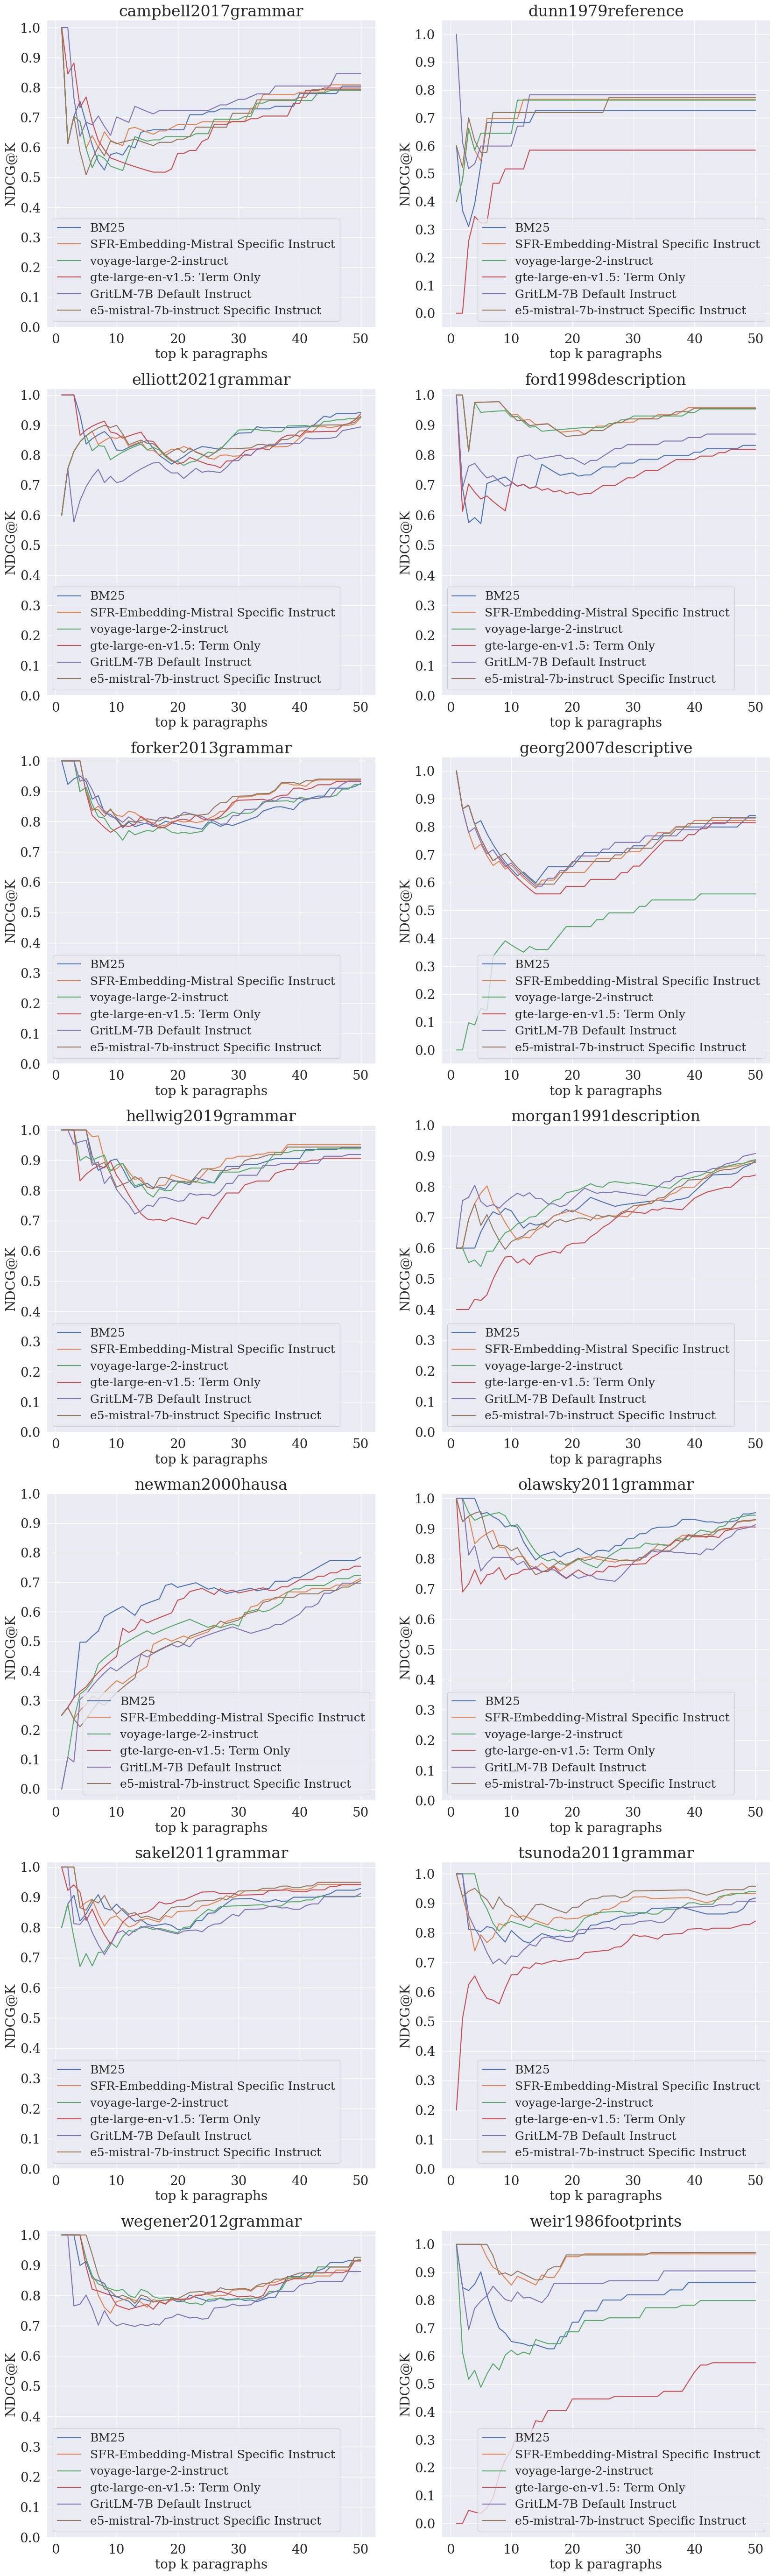

In [ ]:
x = range(1, 51)
plt.rcParams['figure.figsize'] = (20, 70)
fig, axs = plt.subplots(7, 2)
for i in range(7):
    for j in range(2):
        df = pd.read_csv(filepaths_metrics[i * 2 + j])
        for model in best_metrics:
            column = model + ' NDCG@K'
            #if 'NDCG@K' in column and column[:-7] in best_metrics:
            axs[i, j].set_title(os.path.basename(filepaths_metrics[i * 2 + j][:-4]))
            axs[i, j].plot(x, df[column], label=column[:-7])
            axs[i, j].set_yticks([index / 10.0 for index in range(0, 11)])
            axs[i, j].set_xlabel('top k paragraphs')
            axs[i, j].set_ylabel('NDCG@K')
            axs[i, j].legend()
plt.savefig('ndcg.png')

In [ ]:
mean_ndcg_scores = {}
for i in range(14):
    df = pd.read_csv(filepaths_metrics[i])
    for column in df.columns:
        if 'NDCG@K' in column:
            if column[:-7] not in mean_ndcg_scores:
                mean_ndcg_scores[column[:-7]] = [0] * 50
            for k in range(50):
                mean_ndcg_scores[column[:-7]][k] += df[column][k]

for key in mean_ndcg_scores:
    for k in range(50):
        mean_ndcg_scores[key][k] /= 14

### NDCG@20

In [ ]:
for key in mean_ndcg_scores:
    print(f'{key}: {mean_ndcg_scores[key][19]}')

BM25: 0.7493542061563343
SFR-Embedding-Mistral Default Instruct: 0.7526507981332495
SFR-Embedding-Mistral Specific Instruct: 0.7776379258691596
gte-large-en-v1.5: 0.610042434776429
GritLM-7B Default Instruct: 0.7442991752587949
GritLM-7B Specific Instruct: 0.7397611197557533
e5-mistral-7b-instruct Default Instruct: 0.751416940153738
e5-mistral-7b-instruct Specific Instruct: 0.7745951895584156
voyage-large-2-instruct: 0.7346896411634362
SFR-Embedding-Mistral Default Instruct: Term Only: 0.7380780346386723
SFR-Embedding-Mistral Specific Instruct: Term Only: 0.7624634946102573
gte-large-en-v1.5: Term Only: 0.6815884346788073
GritLM-7B Default Instruct: Term Only: 0.7301620756199892
GritLM-7B Specific Instruct: Term Only: 0.7343231782690537
e5-mistral-7b-instruct Default Instruct: Term Only: 0.7330779241127344
e5-mistral-7b-instruct Specific Instruct: Term Only: 0.7497664455802653
voyage-large-2-instruct: Term Only: 0.721739746178932
BM25: Term Only: 0.6660807065972862


### NDCG@50

In [ ]:
for key in mean_ndcg_scores:
    print(f'{key}: {mean_ndcg_scores[key][49]}')

BM25: 0.8756355883164632
SFR-Embedding-Mistral Default Instruct: 0.8762728481110836
SFR-Embedding-Mistral Specific Instruct: 0.8893850178095425
gte-large-en-v1.5: 0.7909635814359081
GritLM-7B Default Instruct: 0.8712256832824874
GritLM-7B Specific Instruct: 0.860341887124434
e5-mistral-7b-instruct Default Instruct: 0.8809026946279868
e5-mistral-7b-instruct Specific Instruct: 0.8919449024991345
voyage-large-2-instruct: 0.8548289543020923
SFR-Embedding-Mistral Default Instruct: Term Only: 0.8661676711791376
SFR-Embedding-Mistral Specific Instruct: Term Only: 0.8797392086202472
gte-large-en-v1.5: Term Only: 0.8257062975439017
GritLM-7B Default Instruct: Term Only: 0.8601093249990235
GritLM-7B Specific Instruct: Term Only: 0.85692416696821
e5-mistral-7b-instruct Default Instruct: Term Only: 0.8650051297893074
e5-mistral-7b-instruct Specific Instruct: Term Only: 0.8731792864231988
voyage-large-2-instruct: Term Only: 0.8496142019850245
BM25: Term Only: 0.8020986447323768


In [ ]:
retriever_names = list(mean_ndcg_scores.keys())

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

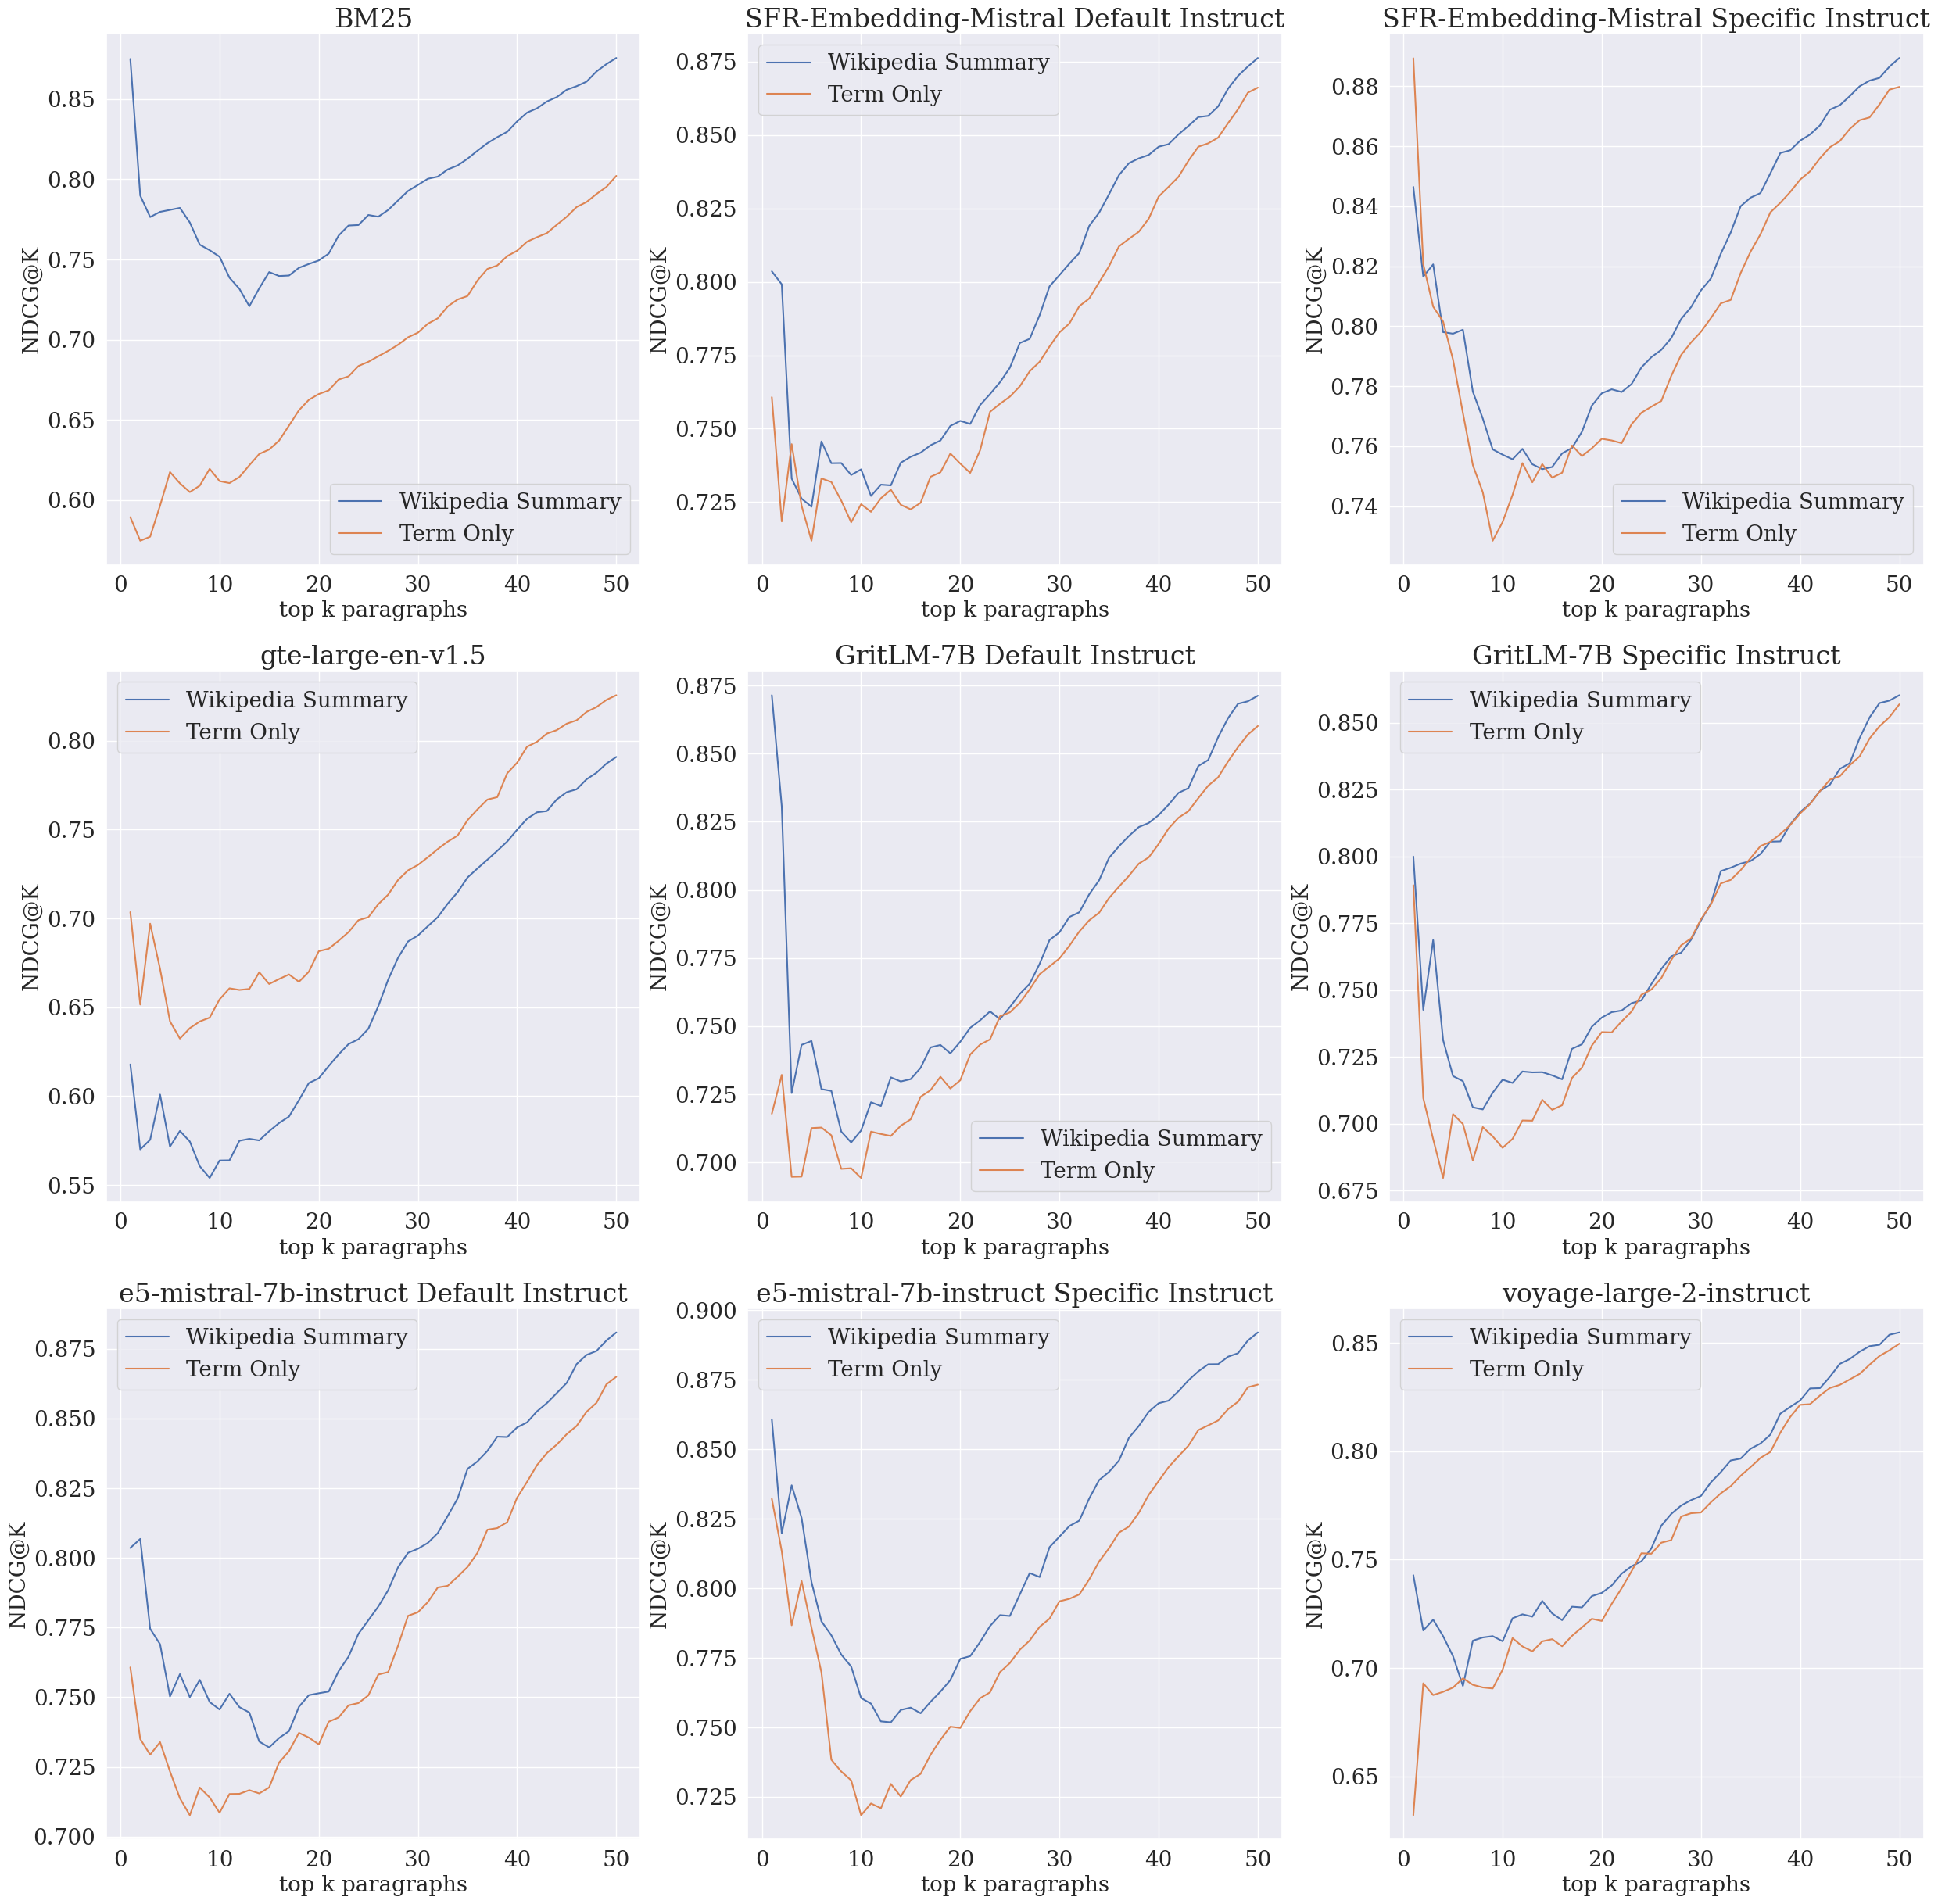

In [ ]:
x = range(1, 51)
plt.rcParams['figure.figsize'] = (30, 30)
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        keys = []
        title = retriever_names[i * 3 + j]
        keys = [title, title + ': Term Only']
        axs[i, j].set_title(title)
        axs[i, j].plot(x, mean_ndcg_scores[keys[0]], label='Wikipedia Summary')
        axs[i, j].plot(x, mean_ndcg_scores[keys[1]], label='Term Only')
        #axs[i, j].set_yticks([index / 10.0 for index in range(0, 11)])
        axs[i, j].set_xlabel('top k paragraphs')
        axs[i, j].set_ylabel('NDCG@K')
        axs[i, j].legend()
plt.savefig('term_only_comparison.png')

## Winner Reranker Inference

In [ ]:
model = SentenceTransformer('Salesforce/SFR-Embedding-Mistral')
model.eval();

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def save_inference(query, model, path_to_paragraphs, df_output_filepath, instruct=None):
    if instruct == None:
        query_embedding = model.encode([query])
    else:
        query_embedding = model.encode([get_detailed_instruct(instruct, query)])
    for i, f_benchmark in enumerate(filenames_for_benchmark):
        df_output = pd.read_csv(df_output_filepath)
        if f_benchmark not in df_output.columns:
            df = pd.read_csv(f'{path_to_paragraphs}{f_benchmark}.csv')
            cos_sim_scores = []
            for k in tqdm(
                range(0, min(len(df['Paragraph']), 50)),
                desc=f'Processing file {i + 1}',
                ncols=100
            ):
                cos_sim_scores.extend(get_scores_on_batch(query_embedding, [df['Paragraph'][k]], model))
            if len(df['Paragraph']) < 50:
                cos_sim_scores.extend([0] * (50 - len(df['Paragraph'])))
            df_output[f_benchmark] = cos_sim_scores
            df_output.to_csv(df_output_filepath, index=False)

In [ ]:
df_with_filenames = pd.read_csv('annotated_benchmark.csv')
filenames_for_benchmark = df_with_filenames['Filename']

In [ ]:
save_inference(
    query,
    model,
    path_to_paragraphs='Grammars Paragraphs/WALS 81A/Wikipedia 50/',
    df_output_filepath='Mistral Similarity Scores/WALS 81A/scores.csv',
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]


In [ ]:
save_inference(
    query,
    model,
    path_to_paragraphs='Grammars Paragraphs/WALS 81A/Wikipedia 50 with layout/',
    df_output_filepath='Mistral Similarity Scores/WALS 81A/scores_with_layout.csv',
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]


In [ ]:
empty_df = pd.DataFrame(columns = ['Paragraph Number'],
             index=range(0, 50))
empty_df.to_csv('Mistral Similarity Scores/GB 107/scores.csv', index=False)
empty_df.to_csv('Mistral Similarity Scores/GB 107/scores_with_layout.csv', index=False)

In [ ]:
save_inference(
    query=get_query('Affirmation and negation', 'en'),
    model=model,
    path_to_paragraphs='Grammars Paragraphs/GB 107/Wikipedia 50/',
    df_output_filepath='Mistral Similarity Scores/GB 107/scores.csv',
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


In [ ]:
save_inference(
    query=get_query('Affirmation and negation', 'en'),
    model=model,
    path_to_paragraphs='Grammars Paragraphs/GB 107/Wikipedia 50 with layout/',
    df_output_filepath='Mistral Similarity Scores/GB 107/scores_with_layout.csv',
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:26<00:00,  1.89it/s]


In [ ]:
empty_df = pd.DataFrame(columns = ['Paragraph Number'],
             index=range(0, 50))
empty_df.to_csv('Mistral Similarity Scores/WALS 116A/scores.csv', index=False)
empty_df.to_csv('Mistral Similarity Scores/WALS 116A/scores_with_layout.csv', index=False)

In [ ]:
save_inference(
    query=get_query('Yes-no question', 'en'),
    model=model,
    path_to_paragraphs='Grammars Paragraphs/WALS 116A/Wikipedia 50/',
    df_output_filepath='Mistral Similarity Scores/WALS 116A/scores.csv',
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:45<00:00,  1.10it/s]


In [ ]:
save_inference(
    query=get_query('Yes-no question', 'en'),
    model=model,
    path_to_paragraphs='Grammars Paragraphs/WALS 116A/Wikipedia 50 with layout/',
    df_output_filepath='Mistral Similarity Scores/WALS 116A/scores_with_layout.csv',
    instruct=specific_instruct
)

In [ ]:
df_with_filenames = pd.read_csv('annotated_benchmark_number_of_cases.csv')
filenames_for_benchmark = df_with_filenames['Filename']

In [ ]:
empty_df = pd.DataFrame(columns = ['Paragraph Number'],
             index=range(0, 50))
empty_df.to_csv('Mistral Similarity Scores/WALS 49A/scores.csv', index=False)
empty_df.to_csv('Mistral Similarity Scores/WALS 49A/scores_with_layout.csv', index=False)

In [ ]:
save_inference(
    query=get_query('Grammatical case', 'en'),
    model=model,
    path_to_paragraphs='Grammars Paragraphs/WALS 49A/Wikipedia 50/',
    df_output_filepath='Mistral Similarity Scores/WALS 49A/scores.csv',
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [02:01<00:00,  2.44s/it]
